### CITS5508 labsheet 5
**Chenxin Hu 22961779**

In this labsheet I'm going to 

1. load the cifar data, split the data into train set and validation set using a ratio 85 - 15.

2. develop a function to display 20 data randomly selected from the set and their class.

3. implemente an MLP classifier, fine tune it and evaluate the model.

4. implemente an CNN classifier, fine tune it and evaluate the model.

5. compare the CNN model and MLP model, summarizing their differences.

#### Import Necessary Libs & Classes

In [1]:
import os
import sys
from data_loader import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
from model_profiler import model_profiler



#### Data preparation and visualisation

In this part I split the data to training set and validation set using a ratio 85:15.

Then a function for displaying 20 random sampled images from the set and their class name was implemented.

The function was called 3 times for training set, validation set and test set.

In [28]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_ori, y_ori = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)
x_train,x_validation,y_train,y_validation = train_test_split(X_ori, y_ori, test_size=0.15, random_state=0)

For train set: 


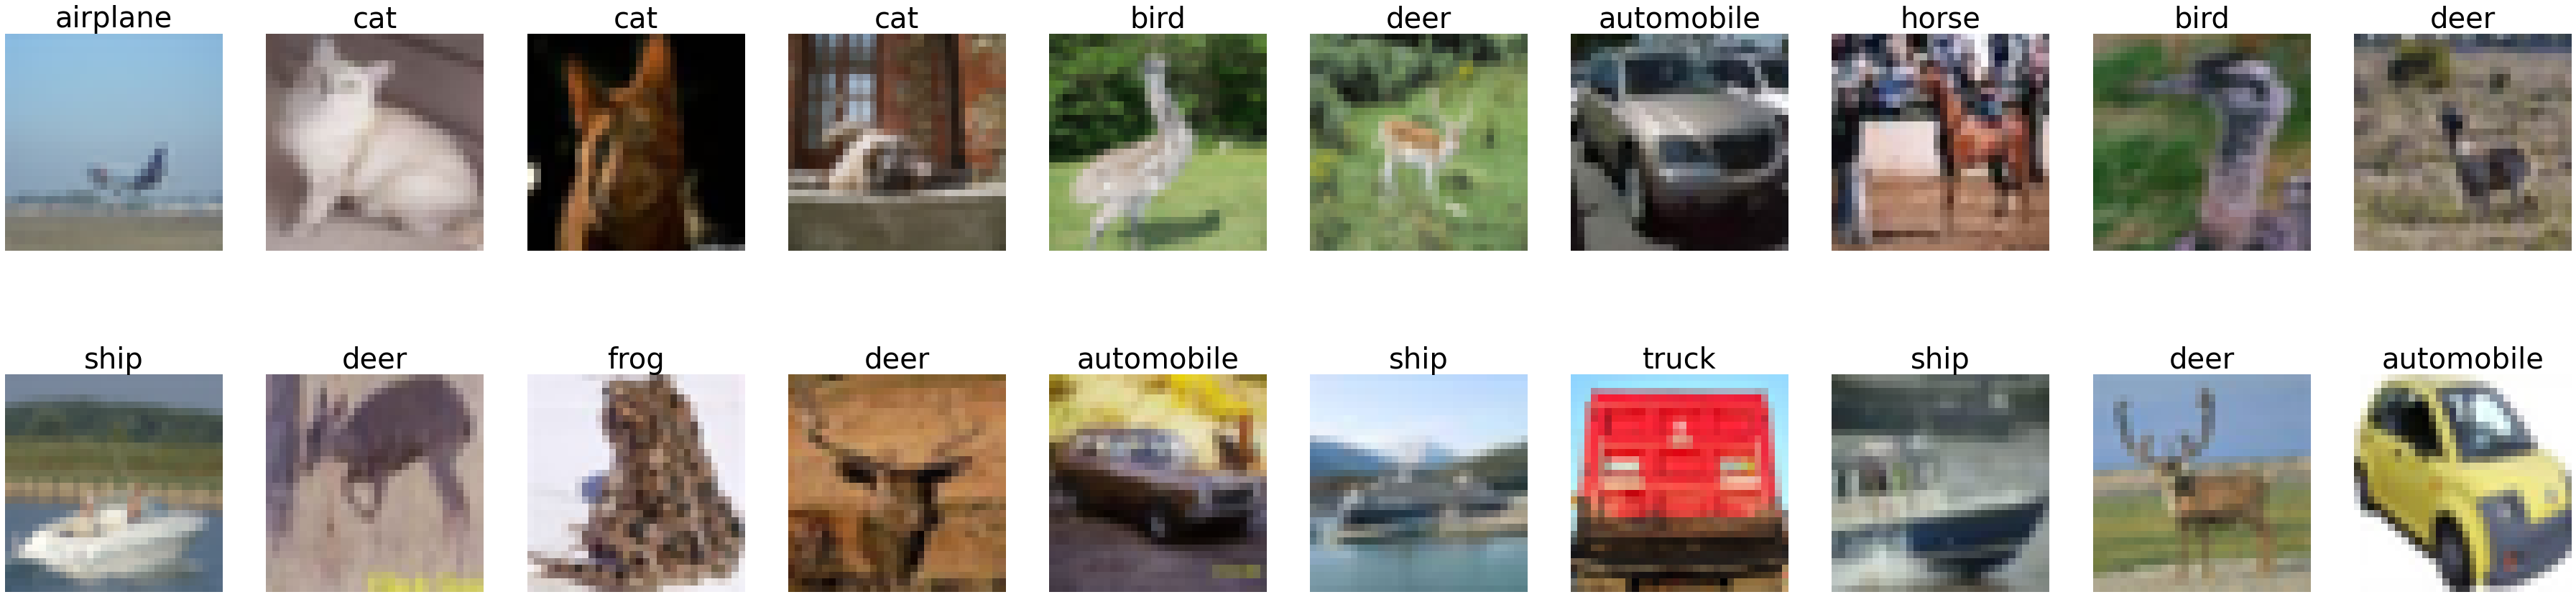

For validation set: 


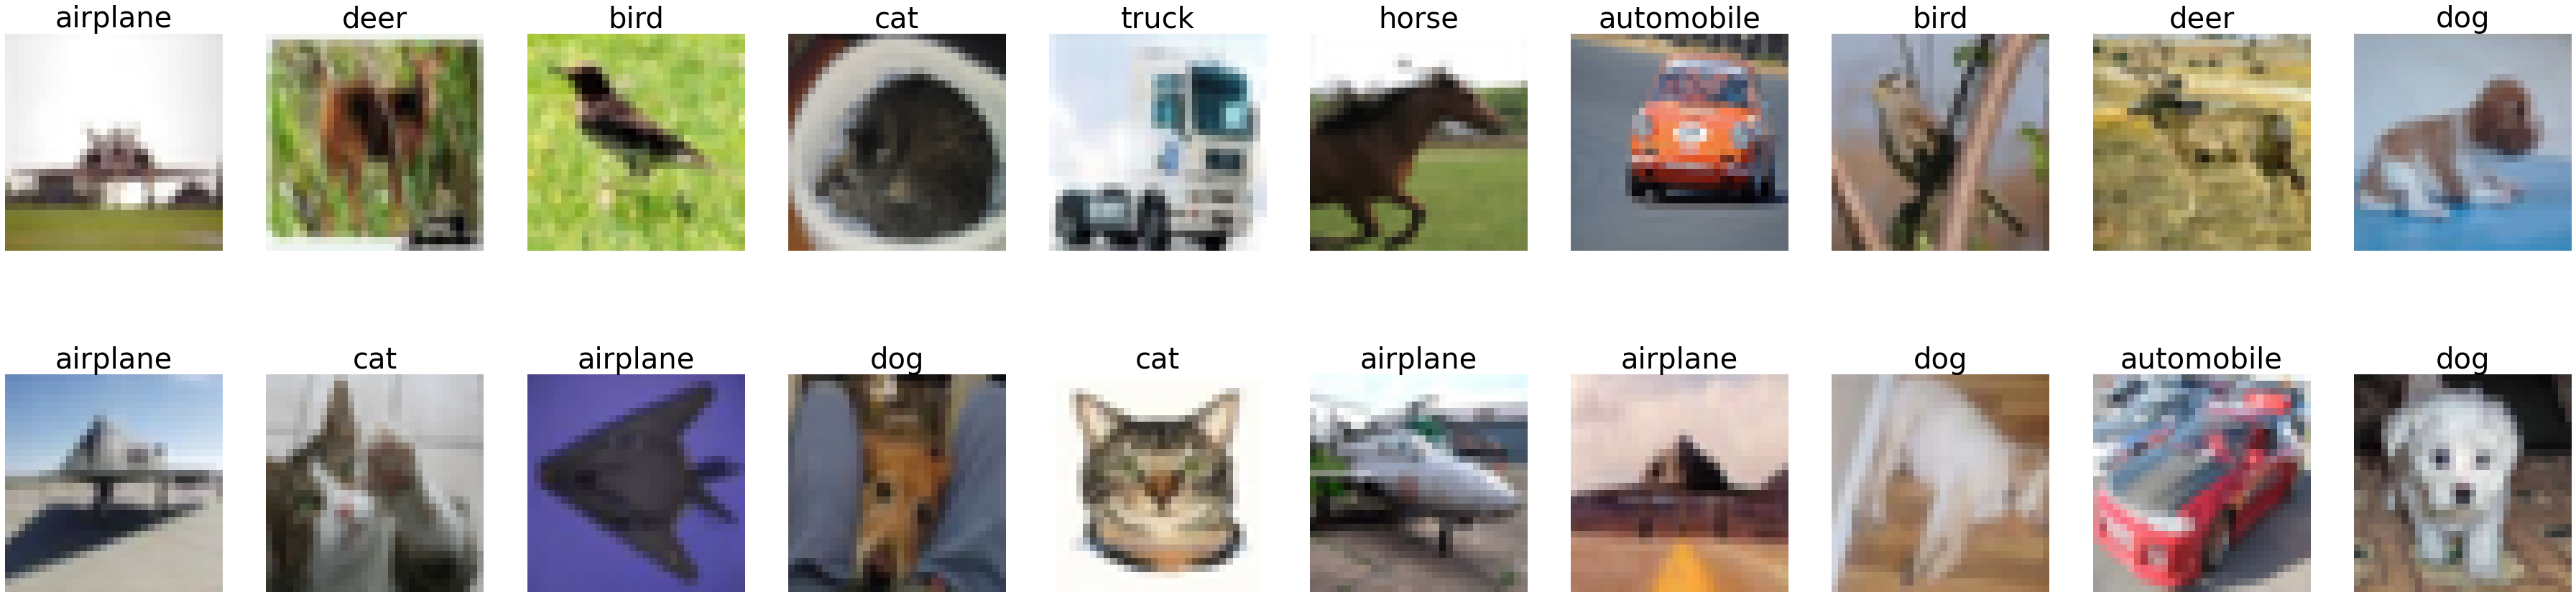

For test set: 


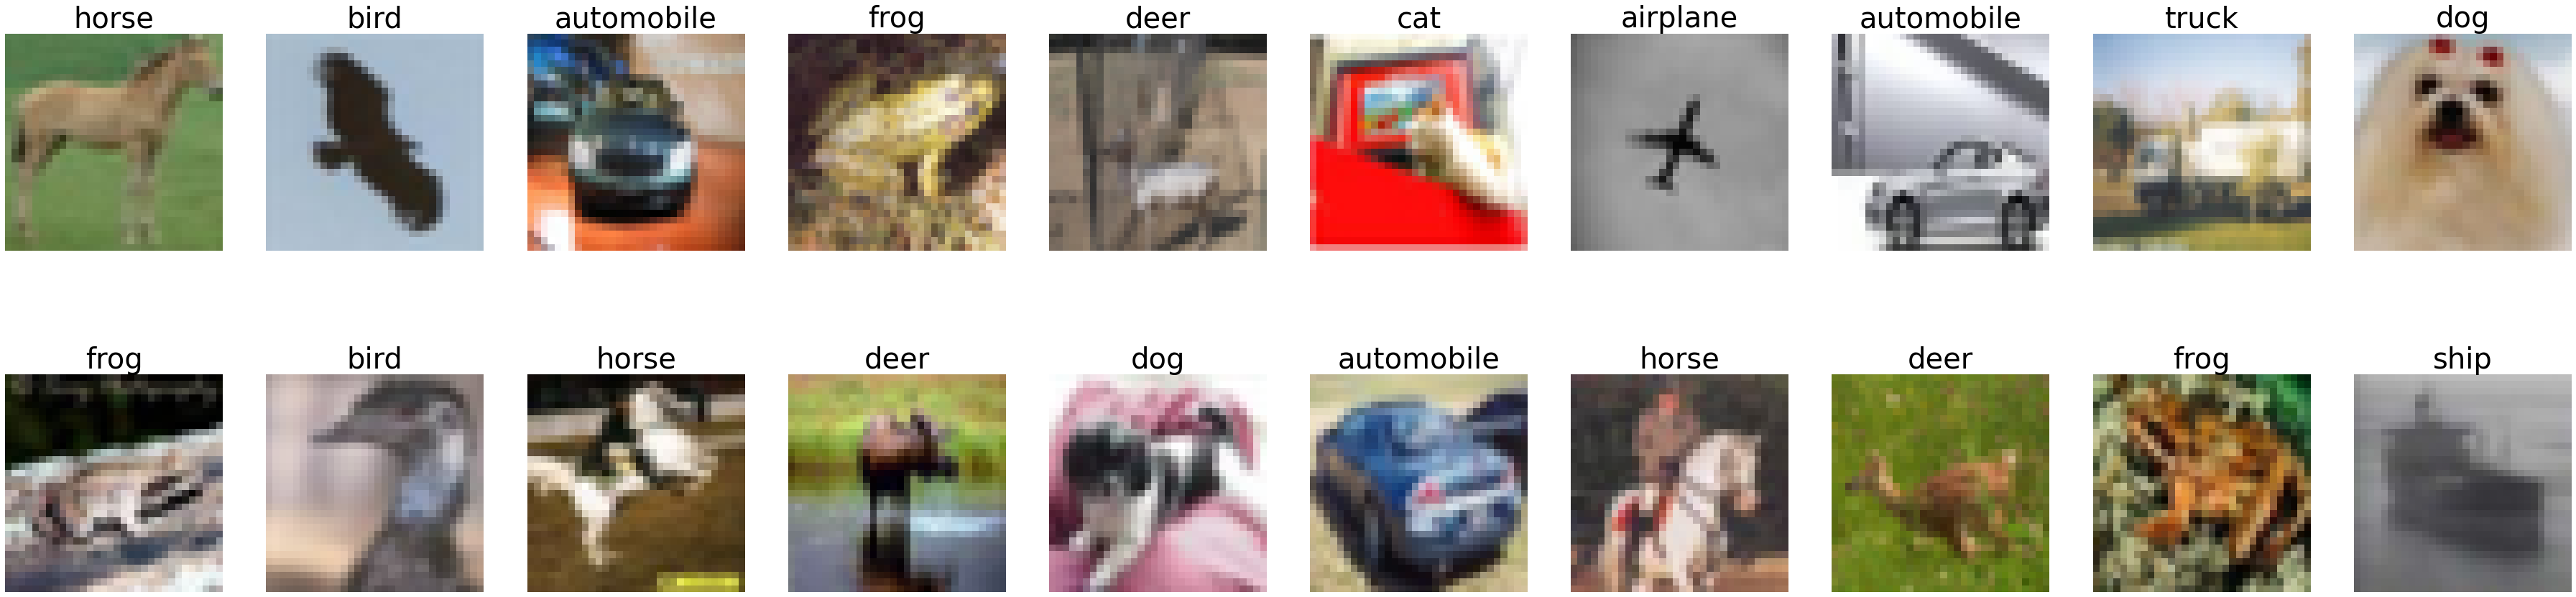

In [29]:
# define a function to display 20 images randomly selected from the set and their class label.
# apply 3 times for train set, validation set and test set.
def displaySampleImage(x_set,y_set):
    plt.figure(figsize=(64,16))
    nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    rdIndex=random.sample(range(0,len(x_set)-1),20)
    plotNum=0
    for i in rdIndex:
        plt.subplot(2,10,plotNum+1)
        plt.axis('off')
        plt.title(nameList[y_set[i]],fontsize=40)
        plt.imshow(x_set[i])
        plotNum=plotNum+1
    plt.show()

print("For train set: ")
displaySampleImage(x_train,y_train)
print("For validation set: ")
displaySampleImage(x_validation,y_validation)
print("For test set: ")
displaySampleImage(X_test,y_test)


#### MLP (a) Hyperparameters

In this part, three possible settings for two hyperparameters: connection weight initialisation & dropout rate were examined using grid search

An early stopping was incorporated and the the patience was set to 10 due to I only train one model for 50 ephochs in grid serach, baseline was set to 0.2 to filter the hyperparametering settings with too low the accuracy.

The early stopping callback will monitoring the accuracy of each ephoch and stops the model fitting when accuracy was not improved in a patience interval upon the baseline.

**Fine tune procedure**
```
best_acc=0
for drop_out in [0.2,0.5,0.8]:
  for init in ["random_normal","random_uniform","variance_scaling"]:
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    model.add(keras.layers.Dense(300,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(200,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(100,kernel_initializer=init,activation="relu"))
    model.add(keras.layers.Dropout(drop_out))
    model.add(keras.layers.Dense(10,activation="softmax"))# 1 neurons per class, total 10 classes
    model.compile(loss="sparse_categorical_crossentropy",
          optimizer="sgd",
          metrics=['accuracy'])
    model.fit(x_train,y_train,epochs=50,validation_data=(x_validation,y_validation),
          callbacks=[EarlyStopping(
              patience=10,
              min_delta=0.05,
              baseline=0.2,
              mode='max',
              monitor='val_accuracy',
              restore_best_weights=True,
              verbose=1)])
    scores=model.evaluate(X_test,y_test)
    if scores[1]>best_acc:
      best_acc=scores[1]
      best_loss=scores[0]
      best_para={'drop_out':drop_out,'init':init}
print(best_acc)
print(best_loss)
print(best_para)
```

#### MLP (b) Architecture & MLP(c) Training and Testing

The model has 3 hidden layers, and each hidden layers have fewer neurons than the input layer.

The dropout rate was set to 0.2 and use random_normal initializer as the fine-tune procedure shows

Information of the model was displayed using *model.summary()*

Then the model was trained for 1 ephoch if it is loaded from local file or 100 ephoches if there's no local file exists.

The model was tested usinng test set and give a loss and accuracy result.

I use sgd as optimizer cause sgd is more suitable for large data set 

And for loss function I use sparse_categorical_crossentropy because it accepts decrete values which classification work would produce.

In [30]:
# load exsiting model or train a new model
if os.path.exists('./Hu_Chenxin-MLP'):
    mlp_model=keras.models.load_model("Hu_Chenxin-MLP")
    mlp_model.summary()
    mlp_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    history=mlp_model.fit(x_train,y_train,epochs=1,validation_data=(x_validation,y_validation))

else:
    mlp_model = keras.models.Sequential()
    mlp_model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    mlp_model.add(keras.layers.Dense(300,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(200,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(100,kernel_initializer="random_normal",activation="relu"))
    mlp_model.add(keras.layers.Dropout(0.2))
    mlp_model.add(keras.layers.Dense(10,activation="softmax"))# 1 neurons per class, total 10 classes
    mlp_model.summary()
    mlp_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    history=mlp_model.fit(x_train,y_train,epochs=100,validation_data=(x_validation,y_validation),
        callbacks=[EarlyStopping(
        patience=10,
        min_delta=0.01,
        baseline=0.2,
        mode='max',
        monitor='val_accuracy',
        restore_best_weights=True,
        verbose=1)])
    mlp_model.save("Hu_Chenxin-MLP")  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               921900    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

#### MLP (d) Classification results

In this part, I'll investgate the classification performance in accuracy, F1 score and precision per class.

A confusion matrices was computed and draw

And I'll anlyze the model complexity and computation time.

From the evaluation we can find that: 

1. The mean accuracy of the mlp model is low, only 0.474, but the accuracy on test set is higher than accuracy the training set and validation set, we can conclude the model has a low accuracy but a high generalization ability

2. The accuracy on predicting cat and bird are significantly lower than the mean accuracy and the accuracy on predicting horse, ship, and truck are significantly higher. From the confusion matrice we can see that the birds are always mixed up with deers and cats always mixed up with dogs, while the shape of cat & dog, bird & deer are familiar (think the deer with two horns are a lot alike to an eagle especially in a blur image), so the model may not be blamed for the low accuracy on these two class.

3. The complexity of the model is low, with number of FLOPs less than 0.01 BFLOPs and 1 million parameters.

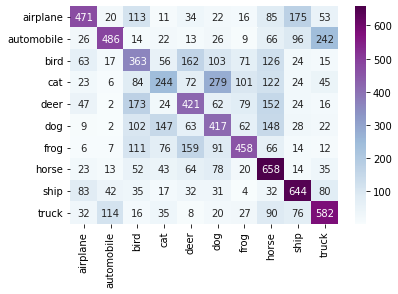

In [31]:
# predict and use the predict result to draw confusion matrices

result = mlp_model.predict(X_test) 
ori_pred = np.argmax(result, axis = 1)
ori_test=y_test
pred=[]
test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(ori_pred)):
    pred.append(nameList[ori_pred[i]])
    test.append(nameList[ori_test[i]])


#print(label)
conf=confusion_matrix(test,pred)
conf_numpy=conf
conf_df=pd.DataFrame(conf_numpy,index=nameList,columns=nameList)
conf_fig = sn.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu") 

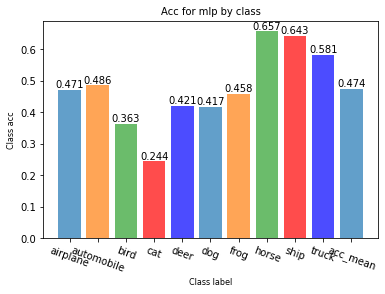

In [32]:
# accuracy by class

acc_list=[]
for i in range(0,10):
    total=1
    right=conf[i][i]
    for j in range(0,10):
        total=total+conf[i][j]
    acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
y_data=acc_list

acc_list = np.array(acc_list)

y_data.append(acc_list.mean())


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for mlp by class", fontdict={'size': 10})
plt.show()

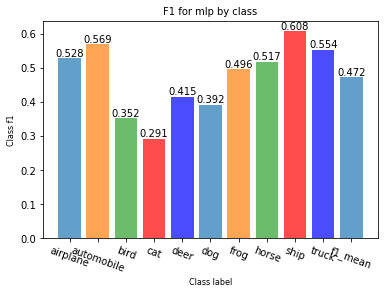

In [33]:
# F1 score by class

precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","f1_mean"]
y_data=f1_list.tolist()
y_data.append(f1_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class f1", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("F1 for mlp by class", fontdict={'size': 10})
plt.show()

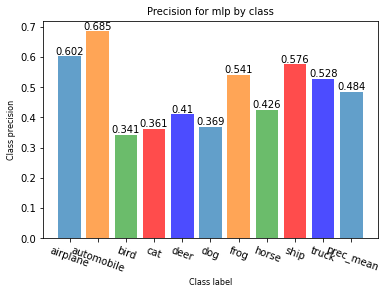

In [34]:
# precision by class
x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","prec_mean"]
y_data=precision_list.tolist()
y_data.append(precision_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class precision", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Precision for mlp by class", fontdict={'size': 10})
plt.show()

In [35]:
# model complexity

Batch_size = 10
profile=model_profiler(mlp_model,Batch_size)
print(profile)


| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0     | BFLOPs  |
| GPU Memory Requirement           | 0.0011  | GB      |
| Model Parameters                 | 1.0032  | Million |
| Memory Required by Model Weights | 3.8269  | MB      |


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### CNN (a) Hyperparameters

In this part, two possible settings for all three hyperparameters were examined using grid serach

An early stopping was incorporated and the the patience was set to 10 due to I only train one model for 50 ephochs in grid serach, baseline was set to 0.2 to filter the hyperparametering settings with too low the accuracy.

The early stopping callback will monitoring the accuracy of each ephoch and stops the model fitting when accuracy was not improved in a patience interval upon the baseline.

**Fine tune procedure**
```
best_acc=0
for k_size in [3,5]:
  for active in ["relu","sigmoid"]:
    for k_num in [64,128]:
      model= keras.models.Sequential([
      keras.layers.Conv2D(k_num,7,activation=active,padding="same",input_shape=[32,32,3]),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(k_num*2,k_size,activation=active,padding="same"),
      keras.layers.Conv2D(k_num*2,k_size,activation=active,padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(k_num*4,k_size,activation=active,padding="same"),
      keras.layers.Conv2D(k_num*4,k_size,activation=active,padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Flatten(),
      keras.layers.Dense(128,kernel_initializer="random_normal",activation=active),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64,kernel_initializer="random_normal",activation=active),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(10,activation="softmax"),
      ])
      model.compile(loss="sparse_categorical_crossentropy",
            optimizer="sgd",
            metrics=['accuracy'])
      model.fit(x_train,y_train,epochs=50,validation_data=(x_validation,y_validation),callbacks=[EarlyStopping(
                patience=10,
                min_delta=0.05,
                baseline=0.2,
                mode='max',
                monitor='val_accuracy',
                restore_best_weights=True,
                verbose=1)])
      scores=model.evaluate(X_test,y_test)
      if scores[1]>best_acc:
        best_acc=scores[1]
        best_loss=scores[0]
        best_para={'k_size':k_size,'active':active,'k_num':k_num}
print(best_acc)
print(best_loss)
print(best_para)
```

#### CNN(b) Architecture & CNN (c) Training and testing

I built a CNN with 2 convolutional layers, pooling layers and batch normalisation using *keras.layers.BatchNormalization()*.

Information of the model was displayed using *summary()*.

From the fine-tune result, I set the layers' k_size as 5 and k_num as 128/256/512 and using active function relu.

I compiled the network using sgd as optimizer and sparse_categorical_crossentropy as loss function.

becaused sgd was more suitable for large data set and loss function sparse_categorical_crossentropy accepts decrete values which classification work would produce.

The model is trained for 1 ephoch if there exists model file, trained for 100 ephoches if there isn't.



In [36]:
# load the model if exists or train a new model

if os.path.exists('./Hu_Chenxin-CNN'):
    cnn_model=keras.models.load_model("Hu_Chenxin-CNN")
    cnn_model.summary()
    cnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    history=cnn_model.fit(x_train,y_train,epochs=1,validation_data=(x_validation,y_validation))
else:
    cnn_model= keras.models.Sequential([
    keras.layers.Conv2D(128,7,activation="relu",padding="same",input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256,5,activation="relu",padding="same"),
    keras.layers.Conv2D(256,5,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512,5,activation="relu",padding="same"),
    keras.layers.Conv2D(512,5,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu",kernel_initializer="random_normal",),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,activation="relu",kernel_initializer="random_normal",),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10,activation="softmax"),
    ])
    cnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="sgd",
        metrics=['accuracy'])
    cnn_model.summary()
    history=cnn_model.fit(x_train,y_train,epochs=100,validation_data=(x_validation,y_validation),
        callbacks=[EarlyStopping(
        patience=10,
        min_delta=0.01,
        baseline=0.2,
        mode='max',
        monitor='val_accuracy',
        restore_best_weights=True,
        verbose=1)])
    cnn_model.save("Hu_Chenxin-CNN")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       18944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       1638656   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 512)        

#### CNN(d) Classification results

In this part, I'll investgate the classification performance in accuracy, F1 score and precision per class.

A confusion matrices was computed and draw

And I'll anlyze the model complexity and computation time.

From the evaluation we can conclude that: 

1. The accuracy of cnn model is high, on training set it can reach an accuracy of 0.99 but on validation set the number is 0.7721. On the test set, the result is slightly lower than the validation set and reaches 0.7655. We can say that the cnn model has a high accuracy but seems that overfitting problem has occuered.

2. On the test set, the prediction accuracy on class deer and class cat is low, the confusion matrix shows that cats are easliy mixed up with dogs and deers easily mixed up with birds. The result proves our speculate that the low accuracy on these two classes was caused by the familiar shape of cats & dogs, deers & birds.

3. The complexity of the cnn model is high, the number of FLOPs for cnn model is 0.0256 BFLOPs and the model has 13.3669 million parameters, which is a high number.

In [37]:
# average accuracy
eval=cnn_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

313/313 [==============================] - 4s 12ms/step - loss: 1.0657 - accuracy: 0.7655
loss is: 1.0657497644424438
acc is: 0.765500009059906


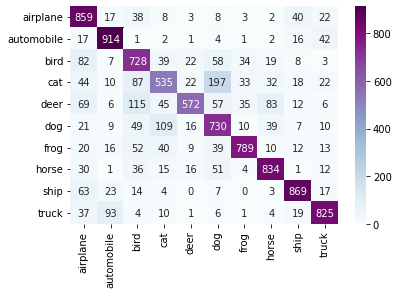

In [38]:
# predict and use the predict result to draw confusion matrices

result = cnn_model.predict(X_test) 
ori_pred = np.argmax(result, axis = 1)
ori_test=y_test
pred=[]
test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(ori_pred)):
    pred.append(nameList[ori_pred[i]])
    test.append(nameList[ori_test[i]])


#print(label)
conf=confusion_matrix(test,pred)
conf_numpy=conf
conf_df=pd.DataFrame(conf_numpy,index=nameList,columns=nameList)
conf_fig = sn.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu") 

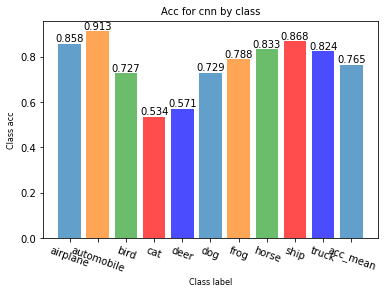

In [39]:
# accuracy by class

acc_list=[]
for i in range(0,10):
    total=1
    right=conf[i][i]
    for j in range(0,10):
        total=total+conf[i][j]
    acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
y_data=acc_list

acc_list = np.array(acc_list)

y_data.append(acc_list.mean())


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for cnn by class", fontdict={'size': 10})
plt.show()

In [40]:
precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)

for i in range(0,10):
    print("For class "+str(nameList[i])+" The F1 score is: "+str(f1_list[i]))
print('The mean F1 score is: ',f1_list.mean())

For class airplane The F1 score is: 0.7662801070472791
For class automobile The F1 score is: 0.8721374045801528
For class bird The F1 score is: 0.6854990583804143
For class cat The F1 score is: 0.5921416712783618
For class deer The F1 score is: 0.6883273164861612
For class dog The F1 score is: 0.6768660176170608
For class frog The F1 score is: 0.8261780104712042
For class horse The F1 score is: 0.8224852071005917
For class ship The F1 score is: 0.868131868131868
For class truck The F1 score is: 0.8367139959432048
The mean F1 score is:  0.7634760657036298


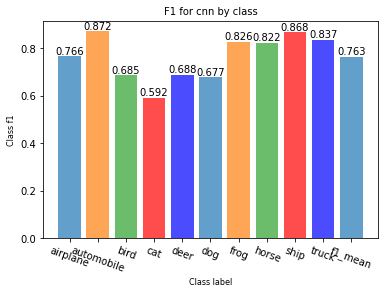

In [41]:
# F1score by class
precision_list, recall_list, f1_list, support_micro=precision_recall_fscore_support(
                y_true=test, y_pred=pred, labels=nameList, average=None)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","f1_mean"]
y_data=f1_list.tolist()
y_data.append(f1_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class f1", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("F1 for cnn by class", fontdict={'size': 10})
plt.show()

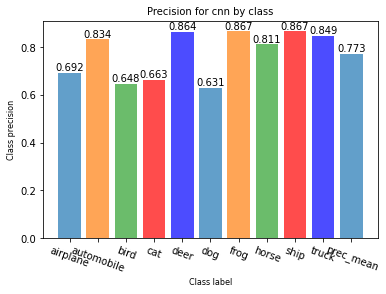

In [42]:
# precision by class
x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","prec_mean"]
y_data=precision_list.tolist()
y_data.append(precision_list.mean())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
bars=plt.bar(x_data, y_data,color=colors,alpha=0.7)
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class precision", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Precision for cnn by class", fontdict={'size': 10})
plt.show()

In [43]:
# model compleixty

Batch_size = 10
profile=model_profiler(cnn_model,Batch_size)
print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0256  | BFLOPs  |
| GPU Memory Requirement           | 0.0271  | GB      |
| Model Parameters                 | 13.3669 | Million |
| Memory Required by Model Weights | 50.9905 | MB      |


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### MLP & CNN Comparis on & Summary

In this part I compared the accuracy of MLP and CNN models in

1. classification accuracies
2. confusion matrices
3. model's complexity
4. classes where one model worked but the other failed
5. classes where both worked well or failed
6. training time


Firstly, we compare the mean accuracy of these two models.

The cnn model reaches an accuracy of 0.7655 and the mlp model reaches an accuracy of 0.4744.

But we can see that the cnn model's accuracy on training set is 0.99, and the mlp model's accuracy on training set is 0.46.

We can conclude that the cnn model gets a 1.5 times higher accuracy than the mlp model, but the mlp model gets a significantly higher generalization ability than the cnn model.

Cnn model may have an overfitting problem.

In [44]:
eval=mlp_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

eval=cnn_model.evaluate(X_test,y_test)
print("loss is: "+str(eval[0])+'\nacc is: '+ str(eval[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.4728 - accuracy: 0.4744
loss is: 1.4728267192840576
acc is: 0.47440001368522644
313/313 [==============================] - 4s 12ms/step - loss: 1.0657 - accuracy: 0.7655
loss is: 1.0657497644424438
acc is: 0.765500009059906


Then we draw a confusion matrix and accuracy by classes for both two models.

We can see that the confusion matrix are simialr foe both two models, the birds class is easily to be mixed up as dog class and deer class always be mixed up with bird class. The accuracy on the 4 classes are lower than average in both two models.

We can conclude that both model did not work well on class bird, cat, dog and deer. And the accuracy by classes on the two models obeys a samiliar distrubution.

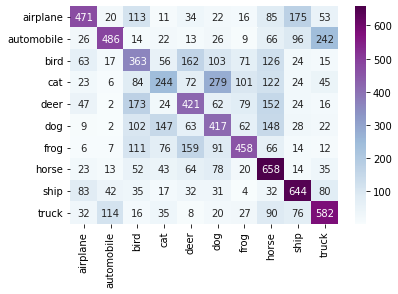

In [45]:
mlp_result = mlp_model.predict(X_test) 
mlp_ori_pred = np.argmax(mlp_result, axis = 1)
mlp_ori_test=y_test
mlp_pred=[]
mlp_test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(mlp_ori_pred)):
    mlp_pred.append(nameList[mlp_ori_pred[i]])
    mlp_test.append(nameList[mlp_ori_test[i]])


#print(label)
mlp_conf=confusion_matrix(mlp_test,mlp_pred)
mlp_conf_df=pd.DataFrame(mlp_conf,index=nameList,columns=nameList)
mlp_conf_fig = sn.heatmap(mlp_conf_df, annot=True, fmt="d", cmap="BuPu") 



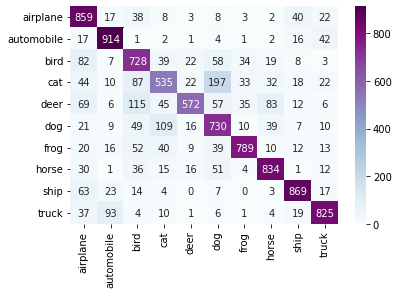

In [46]:
cnn_result = cnn_model.predict(X_test) 
cnn_ori_pred = np.argmax(cnn_result, axis = 1)
cnn_ori_test=y_test
cnn_pred=[]
cnn_test=[]

 
nameList=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(0,len(cnn_ori_pred)):
    cnn_pred.append(nameList[cnn_ori_pred[i]])
    cnn_test.append(nameList[cnn_ori_test[i]])


#print(label)
cnn_conf=confusion_matrix(cnn_test,cnn_pred)
cnn_conf_df=pd.DataFrame(cnn_conf,index=nameList,columns=nameList)
cnn_conf_fig = sn.heatmap(cnn_conf_df, annot=True, fmt="d", cmap="BuPu") 

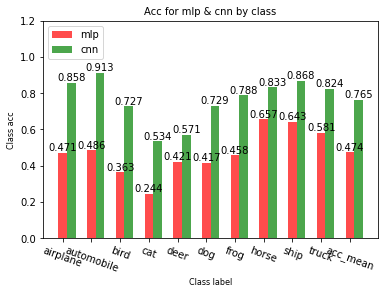

In [47]:
# mlp acc
mlp_acc_list=[]
for i in range(0,10):
    total=1
    right=mlp_conf[i][i]
    for j in range(0,10):
        total=total+mlp_conf[i][j]
    mlp_acc_list.append(right/total)


x_data=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck","acc_mean"]
mlp_y_data=mlp_acc_list

mlp_acc_list = np.array(mlp_acc_list)

mlp_y_data.append(mlp_acc_list.mean())


# cnn acc

cnn_acc_list=[]
for i in range(0,10):
    total=1
    right=cnn_conf[i][i]
    for j in range(0,10):
        total=total+cnn_conf[i][j]
    cnn_acc_list.append(right/total)
cnn_y_data=cnn_acc_list

cnn_acc_list = np.array(cnn_acc_list)

cnn_y_data.append(cnn_acc_list.mean())


bars=plt.bar(x_data, mlp_y_data,color='red',width=0.3,alpha=0.7,label='mlp')
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
bars=plt.bar(np.arange(len(mlp_y_data))+0.3, cnn_y_data,color='green',width=0.3,alpha=0.7,label='cnn')
for bar in bars:  
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)), size=10, ha='center', va='bottom')
plt.xlabel("Class label", fontdict={'size': 8})
plt.ylabel("Class acc", fontdict={'size': 8})
plt.xticks(rotation=-20)
plt.title("Acc for mlp & cnn by class", fontdict={'size': 10})
plt.ylim (0,1.2)
plt.legend(loc='upper left')

plt.show()


In the end, we compared the model complexity for the two models.

We can obtained that the cnn model has a 0.0256 BFLOPs while mlp model has only less than 0.0001.

The cnn model has 13.3669 million of parameters while mlp model has 1.0032 million.

The cnn model is much more complex than the mlp model.

In [48]:
Batch_size = 10
profile=model_profiler(mlp_model,Batch_size)
print(profile)
Batch_size = 10
profile=model_profiler(cnn_model,Batch_size)
print(profile)

| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0     | BFLOPs  |
| GPU Memory Requirement           | 0.0011  | GB      |
| Model Parameters                 | 1.0032  | Million |
| Memory Required by Model Weights | 3.8269  | MB      |
| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0256  | BFLOPs  |
| GPU Memory Requirement           | 0.0271  | GB      |
| Model Parameters                 | 13.3669 | Million |
| Memory Required by Model Weights | 50.9905 | MB      |


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In conclusion

1. Cnn model gets a much higher accuracy than mlp model.

2. Mlp model gets a better genralization ability.

3. Overfitting problem may occur on cnn model.

4. The performance (in confusion matrix and accuracy) of the two models obeys a similar distribution.

5. Both model do not work well on cat & dog, deer & bird, because the similar shape for these objects.

6. Cnn model is more complex than the mlp model, and gets a longer training time.